<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Dataset-Object" data-toc-modified-id="A-Dataset-Object-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Dataset Object</a></span><ul class="toc-item"><li><span><a href="#Compiling-pollution-data" data-toc-modified-id="Compiling-pollution-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Compiling pollution data</a></span></li></ul></li><li><span><a href="#Labeling-the-Fire" data-toc-modified-id="Labeling-the-Fire-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Labeling the Fire</a></span><ul class="toc-item"><li><span><a href="#Check-the-labeling-function" data-toc-modified-id="Check-the-labeling-function-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Check the labeling function</a></span></li><li><span><a href="#Label-country" data-toc-modified-id="Label-country-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Label country</a></span></li></ul></li><li><span><a href="#Understanding-the-GDAL-file" data-toc-modified-id="Understanding-the-GDAL-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Understanding the GDAL file</a></span></li><li><span><a href="#Coordinate-transformation" data-toc-modified-id="Coordinate-transformation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Coordinate transformation</a></span></li></ul></div>

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
import src
from src.imports import *
from src.gen_functions import *
# import the Dataset object class
from src.features.dataset import Dataset
from src.features.landuse import *
from src.visualization.mapper import *

plt.rcParams.update({'font.size': 16})

# A Dataset Object

It is more convenience to have a `Dataset` object that keep tracks of all relavant data for a city along with necessary meta information such as city location etc. This is object is under `src.features.dataset.py`.

The `Dataset` object is also in charge of compile raw pollution, weather, fire data from the data folder into a ready-to-use format using `dataset.build_all_data()`. The processed data are saved under ../data/city_name/. The code below illustrates how to `Dataset` object compile the data using a build_all_data command. This object also keep track of feature engineering parameters during the model optimization step[notebook](https://github.com/worasom/aqi_thailand2/blob/master/notebooks/5.0-ML_ChiangMai.ipynb). For the Dataset object's documentation, please refer to https://github.com/worasom/aqi_thailand2/blob/master/docs/_build/html/src.features.html.

In [ ]:
# init a dataset object and build the data from scratch 
# only perform this when new data files are added 
dataset = Dataset('Chiang Mai')

# build pollution,  weather data and (optional) fire data
dataset.build_all_data( build_fire=True, build_holiday=True)

th_stations ['35t', '36t']
Averaging data from 3 stations
Loading all hotspots data. This might take sometimes


`dataset.build_all_data()` calls four functions: 
- `dataset.build_pollution()`: compiles pollution data form all available sources, averages all the pollution data, and add as `dataset.poll_df` attribute. 
- `dataset.build_weather()`: load weather data, fills the missing, and add as `dataset.wea`.
- `dataset.build_fire()`: Compile the satellite data files into a `dataset.fire` dataframe.
- `dataset.build_holiday()`: scrapes holiday information from the website and save as a csv file. 
    
These function can be called separately when needing to update any data.

After the building process, which might take sometimes because of the size of the fire data (building the fire data is optional and can be set to false (`build_fire=False`). The complied data can be loaded using `_load()` command.

In [2]:
# load saved process data 
dataset = Dataset('Chiang Mai')
dataset.load_()

The hourly pollution data, weather data, and fire data are under `dataset.poll_df`, `dataset.wea` and `dataset.fire` attributes accordingly. Each data is a panda dataframe with datetime index. For example, the pollution data for Chiang Mai looks like

In [48]:
print(dataset.poll_df.tail(2).to_markdown())

| datetime            |   PM2.5 |   PM10 |   O3 |   CO |   NO2 |   SO2 |
|:--------------------|--------:|-------:|-----:|-----:|------:|------:|
| 2020-06-17 15:00:00 |     8.5 |   19.5 |   15 | 0.4  |     5 |     1 |
| 2020-06-17 16:00:00 |     7.5 |   16.5 |   11 | 0.43 |     5 |     1 |


Additionally the dataset also has city information under `city_info` attribute

In [27]:
dataset.city_info

{'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok',
 'lat_km': 2117.0,
 'long_km': 11019.0}

## Compiling pollution data

`dataset.build_pollution()` compiles data from many data sources and average them into a single dataframe under `dataset.poll_df` attribute. Internally, this function calls `dataset.collect_stations_data()` for a list of pollution dataframes from different sources. It calls many functions in `src.data.read_data.py`. Here, I will explain `dataset.collect_stations_data()` function. 

Below is the definition of this function

In [ ]:
    def collect_stations_data(self):
        """Collect all Pollution data from a different sources and take the average.

        Since each city have different data sources. It has to be treat differently. 
        The stations choices is specified by the config.json

        Returns: a list of dataframe each dataframe is the data from all station.

        """
        # data list contain the dataframe of all pollution data before merging
        # all of this data has 'datetime' as a columns
        data_list = []

        # load data from Berkeley Earth Projects This is the same for all cities
        b_data, _ = read_b_data(self.main_folder + 'pm25/' + self.city_name.replace(' ', '_') + '.txt')
        data_list.append(b_data)

        try:
            # load config_dict for the city 
            config_dict = self.config_dict[self.city_name]
        except:
            config_dict = {}
        
        # load thailand stations if applicable 
        if 'th_stations' in config_dict.keys():
            station_ids = config_dict['th_stations']
            print('th_stations', station_ids)
            self.merge_new_old_pollution(station_ids)
            # load the file
            for station_id in station_ids:
                filename = self.data_folder + station_id + '.csv'
                data = pd.read_csv(filename)
                data['datetime'] = pd.to_datetime(data['datetime'])
                data_list.append(data)
        # load the Thailand stations maintained by cmucdc project 
        if 'cmu_stations' in config_dict.keys():
            station_ids = config_dict['cmu_stations']
            print('cmu_stations', station_ids)
            for station_id in station_ids:
                filename = self.main_folder + 'cdc_data/' + str(station_id) + '.csv' 
                data_list.append(read_cmucdc(filename))
        
        if 'b_stations' in config_dict.keys():
            # add Berkeley stations in near by provinces 
            station_ids = config_dict['b_stations']
            print('add Berkerley stations', station_ids)
            for station_id in station_ids:
                b_data, _ = read_b_data(self.main_folder + 'pm25/' + f'{station_id}.txt')
                data_list.append(b_data)

        if 'us_emb' in config_dict.keys():
            # add the data from US embassy 
            print('add US embassy data')
            data_list += build_us_em_data(city_name=self.city_name,
                                                    data_folder=f'{self.main_folder}us_emb/')

        return data_list 

`src.data.read_data.read_b_data()` loads the [Berkeley project](http://berkeleyearth.org/) data using the `self.city_name`. This data is common for all the cities. For the other data sources, the availability varies, so it must be specified in `src.features.config.py`. The dictionary in this function is added as `dataset.conf_dict` attribute. 

For example for **Chiang Mai**, it says 

In [66]:
print('Chiang Mai stations ', dataset.config_dict )

Chiang Mai stations  {'th_stations': ['35t', '36t']}


This means that for Chiang Mai, include the data form two Thailand DPC stations: '35t', '36t', in addition to the Berkeley project data. The function dataset.merge_new_old_pollution() compiled the historical data and scraped data for each station and save under `../data/city_name/` folder. The merged data is then read and append to the data_list. 

For **Nakhon Si Thammarat**, the config_dict says

In [69]:
print('Nakhon Si Thammarat', dataset.config_dict )

Nakhon Si Thammarat {'th_stations': ['42t', 'm3'], 'cmu_stations': [118]}


For Nakhon Si Thammarat, I borrow the data from the near by province (station '42t'), in addition to the mobile station 'm3'. Then I also include the data from [Chiang Mai University Monitoring Stations](https://www.cmuccdc.org/), station number 118. This is done by calling `src.data.read_data.read_cmucdc()`

To check for Thailand DPC's stations number, use `src.data.read_data.get_th_stations().

In [75]:
src.data.read_data.get_th_stations('Chiang Mai')

(['35t', '36t'],
 [{'stationID': '35t',
   'nameTH': 'ศูนย์ราชการจังหวัดเชียงใหม่ ',
   'nameEN': 'City Hall, Chiangmai',
   'areaTH': 'ต.ช้างเผือก อ.เมือง, เชียงใหม่',
   'areaEN': 'Chang Phueak, Meuang, Chiang Mai',
   'stationType': 'GROUND',
   'lat': '18.840633',
   'long': '98.969661',
   'LastUpdate': {'date': '2020-09-17',
    'time': '23:00',
    'PM25': {'value': '15', 'unit': 'µg/m³'},
    'PM10': {'value': '27', 'unit': 'µg/m³'},
    'O3': {'value': '18', 'unit': 'ppb'},
    'CO': {'value': '-', 'unit': 'ppm'},
    'NO2': {'value': '0', 'unit': 'ppb'},
    'SO2': {'value': '0', 'unit': 'ppb'},
    'AQI': {'Level': '1', 'aqi': '15'}}},
  {'stationID': '36t',
   'nameTH': 'โรงเรียนยุพราชวิทยาลัย ',
   'nameEN': 'Yupparaj Wittayalai School',
   'areaTH': 'ต.ศรีภูมิ อ.เมือง, เชียงใหม่',
   'areaEN': 'Si Phum, Meuang, Chiang Mai',
   'stationType': 'GROUND',
   'lat': '18.7909205',
   'long': '98.9881062',
   'LastUpdate': {'date': '2020-09-17',
    'time': '23:00',
    'PM25': 

For [Chiang Mai University Monitoring Stations](https://www.cmuccdc.org/), one can search for the station ids from their json file. For example,

In [87]:
station_info_list = requests.get('https://www.cmuccdc.org/api/ccdc/stations').json()

station_ids= []
for station in station_info_list:
    if 'Nakhon Si Thammarat' in station['dustboy_name_en']:
        station_ids.append(station['dustboy_id'])

print(station_ids)

['118']


For **Hanoi**, the configuration file says

In [68]:
print('Hanoi stations ', dataset.config_dict)

Hanoi stations  {'b_stations': ['Ha_Dong'], 'us_emb': True}


# Labeling the Fire

I used NASA landuse data from  https://lpdaac.usgs.gov/products/mcd12q1v006/.  I used the https://lpdaac.usgs.gov/tools/appears/ to extract the data for the area around ASEAN. For those who are new to this data type. In the later sections, I will explain some details of how to extract data.  
 
Labeling the hotspot uses a single command `label_landuse_file()` function. This function takes hotspots data file with latitude and longitude of the hotspots(fire_m.csv). It will look for that file in the input_folder and save the labeled file as fire_m_label.csv

The function looks like this. 

In [ ]:
def label_landuse_fire(filename, landuse_file='../data/landuse_asean/MCD12Q1.006_500m_aid0001.nc', fire_chunk=1E4, lc_list= ['LC_Prop2', 'LC_Type1', 'LC_Type5']):
    """Load fire data and satellite data in chunk to prevent out of memory error, add different label types and save as original filename + label.csv

    """
   
    filename = os.path.abspath(filename).replace('\\', '/')
    save_filename = filename.replace('.csv', '_label.csv')

 
    # remove old file

    if os.path.exists(save_filename):
        os.remove(save_filename)

    gl_prop = load_gl(landuse_file)
    # keep some columns of the original file
    cols = ['datetime', 'latitude', 'longitude', 'distance', 'long_km', 'lat_km']
    # select the landuse labels types
    lc_list = ['LC_Prop2', 'LC_Type1', 'LC_Type5']


    for fire in tqdm(pd.read_csv(filename, chunksize=fire_chunk)):

        fire['datetime'] = pd.to_datetime(fire['datetime'] )
        fire = fire[cols]

        # add sinusodal coordinate using longitude and latitude
        fire = add_sinu_col(fire)
        years = fire['datetime'].dt.year.unique() 

        for lc_name in lc_list:

            label_all = []
            for year in years:
                # extract fire for that year 
                sub_fire = fire[fire['datetime'].dt.year==year]
                # obtain lc, band_index for that year, label, and coordinate information 
                lc, band_index, label_dict = get_lc_data(lc_name, year, *gl_prop)
                # obtain the label number
                labels_df = get_label(sub_fire, lc, lc_name, band_index)
                # add the label text 
                labels_df = labels_df.merge(label_dict, left_on=lc_name, right_index=True, how='left')
                label_all.append(labels_df)
                
            label_all = pd.concat(label_all, ignore_index=False)
            fire = fire.merge(label_all, left_index=True, right_index=True, how='left')

        fire = fire.drop(['long_sinu_m', 'lat_sinu_m'], axis=1)
        #fire = add_merc_col(fire, unit='km')
        
        fire = combine_label(fire, lc_list=lc_list)
        
        # save the file 
        if os.path.exists(save_filename):
            fire.to_csv(save_filename, mode='a', header=None, index=False)
        else:
            
            fire.to_csv(save_filename, index=False)

In [ ]:
# label location of the fire using landuse data around chiang mai
# this command generate another file named '../data/chiang_mai/' + 'fire_m_label.csv' 
# I don't wanna save over the old file to prevent accidently save over the labeling information 
label_landuse_fire('../data/bangkok/' + 'fire_m.csv')

In the rest of this section, I explains the inside of the `label_landuse_fire()` function.

## Check the labeling function 

The important function inside `label_landuse_file()` is the `get_label()`, which assigned the labels from all lc label types.  

In [ ]:
def get_label_row(row, lc_name, data_arr, buffer_pix=5):
    """Look up landuse data around the buffer pixels(buffer_pix). 
    
    Args:
        row: a single row with xpix and ypix 
        lc_name: lc_name to condition for crop, forrest 
        data_arr: landuse data array
        buffer_pix: buffer area (depends on the resolution of the data) I use 5 because the fire data has resolution of 1km, which about 2 time the landuse resolution.
    
    Return  a single label biased toward crop, forrest, and scrupland. 
    
    """
    
    x = np.arange(row['xpix'], row['xpix']+buffer_pix)
    x = x[x < data_arr.shape[1]]
    y = np.arange(row['ypix'], row['ypix']+buffer_pix)
    y = y[y < data_arr.shape[0]]
    xx, yy = np.meshgrid(x, y)
    xx = xx.flatten()
    yy = yy.flatten()
    labels = data_arr.take(yy, axis=0)
    labels = labels.take(xx, axis=1)
    labels = np.diagonal(labels)
     
    
    if lc_name == 'LC_Prop2':
        if (25 in labels) or (35 in labels) or (36 in labels):
            label = 25
        elif 40 in labels:
            label = 40

        else:
            label = np.bincount(labels).argmax()
    
    elif lc_name == 'LC_Type1':
        
        if (12 in labels) or (14 in labels):
            label = 12
        elif (6 in labels) or (7 in labels) or (9 in labels) or (10 in labels) or (16 in labels):
            label = 6
       
        else:
            label = np.bincount(labels).argmax()
    
    elif lc_name == 'LC_Type5':
        if (8 in labels) or (7 in labels):
            label = 8
        elif (6 in labels) or (11 in labels) or (5 in labels) :
            label = 6
       
        else:
            label = np.bincount(labels).argmax()
            
    else: 
        label = np.bincount(labels).argmax()
        
    return label 

    
def get_label(df, lc, lc_name, band_index, chunk=1000, buffer_pix=5):
    """Add lc land label to the dataframe using the lat_km and long_km columns. 

    Args:
        df: subset of fire dataframe 
        lc: landuse dataset object
        lc_name: name for the column
        band_index: band_index from the year information
        chunk: chunk size of the sattelite array 
        buffer_pix: number of pixel around area. Should be odd number. 

    Return a series of labeled data. The colum name is the lc name  

    """

    # extract geometrical property and image size

    GT = lc.GetGeoTransform()
    xsize = lc.RasterXSize
    ysize = lc.RasterYSize 

    # obtain the pixel and add buffer_pix offset 
    df['xpix'] = round((df['long_sinu_m'] - GT[0])/GT[1]).astype(int) - floor(buffer_pix/2)
    # divide the size of the grid into four section 
    df['ypix'] = round((df['lat_sinu_m'] - GT[3])/GT[5]).astype(int) - floor(buffer_pix/2)

    # cannot load everything into the memory, so only load the land label in chunk 
    max_iter_y = ceil(ysize/chunk)

    label_df = []

    for j in np.arange(max_iter_y):
        xoff = 0
        yoff = int(chunk*j)
        win_xsize = xsize
        win_ysize = chunk

        # correct the size of the last chunk

        if yoff + win_ysize > ysize:
            win_ysize = ysize - yoff

         
        # extract subdata for that chunk 
        mask = ((df['ypix'] >= yoff) &  (df['ypix'] < yoff+win_ysize))
        # keep only nessary info 
        sub_df = df.loc[mask, ['ypix', 'xpix']]

        if len(sub_df) > 0:
            sub_df['ypix'] -= yoff
            data = lc.GetRasterBand(band_index) 
            data_arr = data.ReadAsArray(xoff=xoff, yoff=yoff, win_xsize=win_xsize, win_ysize=win_ysize)
            labels = sub_df.swifter.apply(get_label_row, axis=1, lc_name=lc_name,data_arr=data_arr)
            sub_df[lc_name] = labels
            # obtain the labels
            label_df.append(sub_df[[lc_name]])

    label_df = pd.concat(label_df, ignore_index=False)

    return label_df

I use the coordinate of BKK, Chiang Mai city and KaoYai natural park to check if the data labeling funciton `get_label()` is correct.

In [67]:
lc_name = 'LC_Type5'
year = 2002

files = glob(land_folder + '*.nc')
print(files[0])

gl_prop = load_gl(files[0])
# obtain data for that year, label, and coordinate information 
lc, band_index, label_dict = get_lc_data(lc_name, year, *gl_prop)

../data/landuse_asean\MCD12Q1.006_500m_aid0001.nc


In [68]:
# coordinate of BKK, Chiang Mai and kao_yai national park
test_df  = pd.DataFrame({ 'longitude': [100.5014, 98.9847, 101.374528 ] , 
                        'latitude': [ 13.754, 18.7904,  14.441845]})
# add sinusodal coordinate 
test_df = add_sinu_col(test_df)
# obtain the label number
labels_df = get_label(test_df, lc, lc_name, band_index)
# add the label text 
labels_df = labels_df.merge(label_dict, left_on=lc_name, right_index=True, how='left')

labels_df

,LC_Type5,LC_Type5_label
1,9,urban
0,9,urban
2,2,forest


## Label country

In addition, one might be interested in adding the country information into the data. This is done using `add_countries()` function.

In [ ]:

def locate_country(p, gdf):
    """Find a country hosting the hotspot.

    Args:
        p: Point object
        gdf: geopandas dataframe with albel 
    
    Returns: str 
        name of the country 
    """
    try: 
        country = gdf[gdf['geometry'].contains(p)]['NAME'].values[0]
    except: 
        country = np.nan
        
    return country

def get_country_gdf(city_xy_m =[],max_distance=1000, map_file = '../data/world_maps/map3/', country_list = ['Thailand', 'China', 'Vietnam', 'Myanmar (Burma)','Cambodia', 'Laos' ]):
    """Obtain ASEAN counties geopandas dataframe

    Args:
        city_xy_km: [city_x_km, city_y_km] of the city center in mercator coordinate
        max_distance: maximum radius of the area considered in km
        map_file
        country_list

    Returns:  geopanda.DataFrame   
        geodataframe used to labeling the country 

    """

    # prepare geopandas file 
    # loading world map
    gdf =  gpd.read_file(map_file)
    gdf.columns = ['OBJECTID', 'NAME', 'geometry']
    gdf = gdf[gdf['NAME'].isin(country_list)].reset_index(drop=True)

    # remove burma from the name 
    name_list = gdf['NAME'].to_list()
    name_list = [s.replace('Myanmar (Burma)', 'Myanmar') for s in name_list]
    gdf['NAME'] = name_list 

    # sometimes additional information is need such as the area of each country within maximum distance from df 
    if len(city_xy_m) > 0:
         
        # create a 1000 km polygon in mercator in meter
        circle_gons = get_circle(x_cen=city_xy_m[0], y_cen=city_xy_m[1], r=max_distance*1000, num_data=1E4)
        # convert into a tuple 
        circle_gons = {'geometry': Polygon(list(map(tuple, circle_gons.transpose())))}
        circle_gons = gpd.GeoDataFrame(circle_gons, crs="EPSG:3857",index=[0])

        # convert to 6933 to get he correct area 
        circle_6933 = circle_gons['geometry'].to_crs(epsg=6933)
        circle_6933 = circle_6933.values[0] 

        temp = gdf.copy()
        # convert to mercator
        temp['geometry'] = gdf['geometry'].to_crs(epsg=6933)

        inter_area = []
        for i, row in temp.iterrows():
            polygon1 = row['geometry'].intersection(circle_6933) 
            inter_area.append(int(polygon1.area/10**6))

        gdf['inter_area(km2)'] = inter_area

        print(inter_area)

    return gdf
                
def add_countries(df, city_xy_m =[], max_distance=1000, map_file = '../data/world_maps/map3/', country_list = ['Thailand', 'China', 'Vietnam', 'Myanmar (Burma)','Cambodia', 'Laos' ]):
    """Add country label of the hotspot 

    Args:
        df:  dataframe with longitude and latitude
        city_xy_km: [city_x_km, city_y_km] of the city center in mercator coordinate
        max_distance 
        map_file
        country_list

    Returns: (pd.DataFrame, geopanda.DataFrame)
        df: df dataframe with country label
        geodataframe used to labeling the country 

    """
    # label the country 
    gdf = get_country_gdf(city_xy_m, max_distance, map_file, country_list)
    df['geometry'] = [Point(x,y) for x, y in zip(df['longitude'], df['latitude'])]
    df['country'] = df['geometry'].swifter.apply(locate_country, gdf=gdf)
    df = df.drop('geometry', axis=1)


    return df

In [2]:
# add country hosting the fires
# obtain the central  coordinate from the dataset object 
dataset = Dataset('Bangkok')
fire = pd.read_csv('../data/bangkok/' + 'fire_m_label.csv')
fire = add_countries(fire, city_xy_m=[dataset.city_info['long_m'], dataset.city_info['lat_m']], filename='../data/bangkok/' + 'fire_m_label.csv')

# Understanding the GDAL file 

Care must be taken when converting coordinate, so below I will show some checking points that I use to make sure coordinate conversion is correct. 

In [4]:
land_folder = '../data/landuse_asean/'
cm_folder = '../data/chiang_mai/'

To open the gdal file:
1. `gdal.Open` 
1. `hdf_file.GetSubDatasets()`
1. To extract a single slice `file1 = hdf_file.GetSubDatasets()[0][0]`. Note  `hdf_file.GetSubDatasets()[0][1]` is just a string.

After extracting the data. The following command is useful for obtaining information.
- GetGeoTransform () : This method returns the 6-element geotransform described in the previous section.
- GetMetadata () : This method returns a dictionary with the metadata items.
- GetRasterBand ( band ): This method selects a band (and returns a pointer to it). In GDAL, band numbers start at 1, rather than 0.
- RasterCount: The number of bands (will be one or more).
- RasterXSize: The size in pixels of the dataset in the horizontal (x) direction
- RasterYSize: The size in pixels of the dataset in the vertical (y) direction
- GetProjectionRef (): Returns the projection reference (as a WKT string)
- ReadAsArray () : Reads the whole dataset as a numpy array of size ( RasterCount, RasterXSize, RasterYSize ). While very convenient, be wary that some datasets are very large, and this will read all of it into memory.
- ReadRaster () : An efficient way of reading a chunk of the dataset.



reference: 
- http://jgomezdans.github.io/gdal_notes/ipython.html
- https://lpdaac.usgs.gov/resources/e-learning/

Gdal file is composed of several kind landuse labels. The `load_gl()` command load the GDAL dataset object, and the references to all the landuse label systems, which I I will call it LC data. 

Each LC dataset object contains different band. Each band is the label for that year. After specifying the band (using the year that I want), the data array containing the labeling can be load. However, the array are too large, therefore only subset of the array is loaded at a time.

In [5]:
files = glob(land_folder + '*.nc')
print(files[0])

gl, lc_dict, label_list = load_gl(files[0])

../data/landuse_asean\MCD12Q1.006_500m_aid0001.nc


After reading the manual data product manual, I think 3 data is useful: LC_type1, LC_type5, LC_Prop2. 

In [6]:
# extract subset 
# LC_Type1
lc1_file = gl.GetSubDatasets()[6][0] 
# LC_Pro2
lc2_file = gl.GetSubDatasets()[2][0]
# LC_Type5
lc5_file = gl.GetSubDatasets()[10][0]

The function below are useful information for coordinate transformation and understanding the label.

In [8]:
# extract lc2 data 
lc2_file = gl.GetSubDatasets()[2][0]
lc =  gdal.Open(lc2_file)

# this tells how many bands there are 
size_str = gl.GetSubDatasets()[2][1]
size_str = re.findall( '(\d+x\d+x\d+)', size_str)[0]

print(f'number of band {size_str}')

# extract geotransformation for coodinate transformation
GT = lc.GetGeoTransform()
print('GeoTransform', GT)

Xpixel = lc.RasterXSize
Yline = lc.RasterYSize
# x max, y max in sinu system
Xgeo = GT[0] + Xpixel*GT[1] + Yline*GT[2]
Ygeo = GT[3] + Xpixel*GT[4] + Yline*GT[5]
print(Xgeo, Ygeo)

# labeling is in the metadata 
print('labeling information', lc.GetMetadata())

number of band 19x10632x12887
GeoTransform (8121408.60801542, 463.31271652777787, 0.0, 3590210.240373751, 0.0, -463.3127165277779)
14092119.585908893 -1335730.561749584
labeling information {'crs#false_easting': '0', 'crs#false_northing': '0', 'crs#grid_mapping_name': 'sinusoidal', 'crs#longitude_of_central_meridian': '0', 'crs#longitude_of_projection_origin': '0', 'crs#semi_major_axis': '6371007.181', 'crs#semi_minor_axis': '6371007.181', 'crs#straight_vertical_longitude_from_pole': '0', 'crs#_CoordinateAxisTypes': 'GeoX GeoY', 'LC_Prop2#Barren': ' 1 \n       Permanent Snow and Ice = 2 \n       Water Bodies = 3  \n       Urban and Built-Up = 9 \n       Dense Forest = 10 \n       Open Forest = 20 \n       Forest Cropland Mosaic = 25 \n       Natural Herbaceous = 30 \n       Natural Herbaceous/Cropland = 35 \n       Herbaceous Croplands = 36  \n       Shrublands = 40 \n       Unclassified = 255', 'LC_Prop2#coordinates': 'time ydim xdim', 'LC_Prop2#grid_mapping': 'crs', 'LC_Prop2#long_na

Let's take a quick look at the data around Bangkok

In [13]:
# obtain the  band index of the data
year = 2002
band_index = int(year - 2001)
 
# BKK coordinate 
win_xsize = 300
win_ysize = 200
xoff = 5800
yoff = 4430
 

data = lc.GetRasterBand(band_index) 
data_arr = data.ReadAsArray(xoff=xoff, yoff=yoff, win_xsize=win_xsize, win_ysize=win_ysize)
 
# replace unclassified data
data_arr[data_arr==255] = -1
print(data_arr.shape)

(200, 300)


Below is the image of the Thai gulf. Chow Praya River flows through the heart of the Bangkok is seen as a wiggle blue line near coordinate (150, 50)

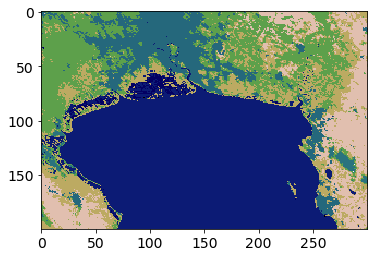

In [14]:
plt.imshow( data_arr, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth)

# Coordinate transformation 

In [645]:
# convert latitude and longitude to sinusodal projection (which is the landuse data coordinate system)
crs_6842 = CRS.from_proj4("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
transformer_6842 = Transformer.from_crs("EPSG:4326", crs_9112) 
coor_6842 = transformer_6842.transform(*(13.754000, 100.501400))
print(coor_6842)

(10854813.157490747, 1529376.7448868759)


In [646]:
ipx = int((coor_6842[0] - GT[0])/GT[1])
ipy = int((coor_6842[1] - GT[3])/GT[5])
print(ipx, ipy)

5899 4448


In [647]:
data_arr = data.ReadAsArray(xoff=ipx, yoff=ipy, win_xsize=50, win_ysize=50)
data_arr[0,0]

9

In [628]:
landuse_df[ (landuse_df['long_m'] > 1.101893e+07) & (landuse_df['lat_m'] < 2.130274e+06)].head()

,lat_m,long_m,land_use
710462,2.129933e+06,1.101913e+07,9
710463,2.129933e+06,1.101962e+07,9
710464,2.129933e+06,1.102011e+07,9
710465,2.129933e+06,1.102060e+07,9
710466,2.129933e+06,1.102109e+07,9


In [51]:
row = test_df.iloc[0]
xpx = round((row['long_m'] - GT[0])/GT[1]) 
ypx = round((row['lat_m'] - GT[3])/GT[5]) 
print(xpx, ypx)
# there is a chance that the xpx and ypx is out of the pixel
#data_arr[ypx, xpx]

6618 4434


In [52]:
row = test_df.iloc[1]
xpx = round((row['long_m'] - GT[0])/GT[1]) 
ypx = round((row['lat_m'] - GT[3])/GT[5]) 
print(xpx, ypx)
# there is a chance that the xpx and ypx is out of the pixel
#data_arr[ypx, xpx]

6254 3181


In [554]:
# Output coordinates are in WGS 84 longitude and latitude
latlong_proj = pyproj.Proj(init='epsg:4326')
# output mercator 
mercator_proj = pyproj.Proj(init='epsg:3395')

# Input coordinates are in meters on the Polar Stereographic 
# projection given in the netCDF file
crs_9112 = pyproj.Proj("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs",preserve_units=True)

lon, lat = pyproj.transform(crs_9112, mercator_proj, *(Xgeo, Ygeo))
print(lon, lat)

14423737.999894785 -1338243.7058742356


In [15]:
# coordinate transfomer
crs_9112 = CRS.from_proj4("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs")
transformer_mer = Transformer.from_crs(crs_9112, "EPSG:3857") 
transformer_mer.transform(*(Xgeo, Ygeo))

(14423737.999894785, -1347131.0217135216)

In [16]:
# create a landuse df
long_arr = []
latitude = []
longitude = []
lat_arr = []
landuse_arr = []


# BKK coordinate 
win_xsize = 300
win_ysize = 200
xoff = 5800
yoff = 4430

data_arr = data.ReadAsArray(xoff=xoff, yoff=yoff, win_xsize=win_xsize, win_ysize=win_ysize)


for i_y in tqdm_notebook(range(data_arr.shape[0])):
    for i_x in range(data_arr.shape[1]):
        # obtain the label
        label = data_arr[i_y, i_x]
        # obtain the coordinate 
        
        coor = ( GT[0] +  (xoff + i_x)*GT[1], GT[3] +  (yoff  + i_y)*GT[5])
        
        if label != 255:
            landuse_arr.append(label)
            
        
            mer_x, mer_y = transformer_mer.transform(*coor)
             
            long_arr.append(mer_x)
            lat_arr.append(mer_y)
        
landuse_df = pd.DataFrame({'lat_m': lat_arr, 
                          'long_m': long_arr, 
                          'land_use': landuse_arr
                           })

print(landuse_df.shape)
#landuse_df = landuse_df[landuse_df['land_use'] != -1]
landuse_df.head()


(59996, 3)


,lat_m,long_m,land_use
0,1.554625e+06,1.114375e+07,9
1,1.554625e+06,1.114422e+07,9
2,1.554625e+06,1.114470e+07,20
3,1.554625e+06,1.114518e+07,20
4,1.554625e+06,1.114566e+07,20


In [17]:
xmap_range = [landuse_df['long_m'].min(), landuse_df['long_m'].max()]
ymap_range = [landuse_df['lat_m'].min(), landuse_df['lat_m'].max()]

In [18]:
colors = get_color(color_length=landuse_df['land_use'].nunique(), cmap = cm.gist_earth) 
mapper = LinearColorMapper(palette=colors, low=landuse_df['land_use'].min(), high=landuse_df['land_use'].max())

In [21]:
#p = plot_basemap(xmap_range, ymap_range, title=None, toolbar_location='below')

p = figure(x_range=xmap_range, y_range=ymap_range, x_axis_type="mercator", y_axis_type="mercator",  toolbar_location='below', 
           plot_width=500, plot_height=500, title='Landuse in Bangkok Area')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

temp = landuse_df.copy()
#temp = temp[temp['land_use'] == 13]

p.rect(x="long_m", y="lat_m", width=500, height=500, source=temp, fill_color={'field': 'land_use', 'transform': mapper}, line_color=None, alpha=0.8)


    
# set colorbar property 
color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="10pt",
                             ticker=BasicTicker(desired_num_ticks=8),
                             label_standoff=6, border_line_color=None, location=(0, 0))

p.add_layout(color_bar, 'right')       
show(p)